# ROMS in Python - Advanced: Singular spectrum analysis

by David Gwyther

This notebook will run through an application of SSA to a timeseries (https://github.com/aj-cloete/pssa/blob/master/Singular%20Spectrum%20Analysis%20Example.ipynb) and a 2D field with time evolution. This uses the python package at the above github. I placed the .py file in a local directory, then loaded it manually (rather than installing it, etc).

More reading: https://www.kaggle.com/code/jdarcy/introducing-ssa-for-time-series-decomposition/notebook
SSA slow/fast map adapted from @kuechenrole https://github.com/kuechenrole/tidal_melting/blob/master/notebooks/exploratory/ssa_filtering.ipynb

In [1]:
# load modules
## Data processing and DA modules
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
## Dealing with big data and netcdf
import xarray as xr
from netCDF4 import Dataset
## ROMS packages
from xgcm import Grid
## color maps
import cmaps
import cmocean
## mapping packages
import cartopy.crs as ccrs
import cartopy.feature as cfeature
## System tools and python configuration
import os
import glob
import repackage
repackage.add('../../')
repackage.add('../')

'/local/m68/deg581/tmp'

In [2]:
cd /g/data/fu5/deg581/OSSE_analysis/notebooks/

/g/data1a/fu5/deg581/OSSE_analysis/notebooks


In [3]:
# cartopy load the coast:

import cartopy.feature as cfeature

def loadCartopyCoast():
    Coast = cfeature.GSHHSFeature(scale='intermediate',levels=[1],facecolor='none') #level 1 is coastline
    return Coast

Coast = loadCartopyCoast()


In [4]:
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(cores=16,processes=1,memory="47GB")
client = Client(cluster)
cluster.scale(cores=48)

/g/data/fu5/deg581/miniconda3/envs/devel3.9/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile
/g/data/fu5/deg581/miniconda3/envs/devel3.9/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36879 instead
  warnings.warn(


In [5]:
print(client)

<Client: 'tcp://10.0.128.139:40519' processes=0 threads=0, memory=0 B>


## load data

In [6]:
# load multiple ROMS netcdf with xr


# filelist = glob.glob('/g/data/fu5/deg581/EAC_2yr_truthRun_obsVerification/output/outer_his_0800*.nc')
# chunks = chunks={'ocean_time':1}
# def RemoveSomeDays(ds):
#     '''remove the last 7 timesteps from each file'''
#     return ds.isel(ocean_time = slice(0,-7))

# ds = xr.open_mfdataset(filelist,chunks, preprocess=RemoveSomeDays, data_vars='minimal', compat='override', coords='minimal', parallel=False, join='right')
# ds

# note that I turned off parallel - was finding it was freezing with dask?
# alternative: load once, chop off vars and save to a processed netcdf, then load with:

ds = xr.open_dataset('/g/data/fu5/deg581/OSSE_analysis/data/proc/output_truth_8005_8401.nc')
ds

<xarray.Dataset>
Dimensions:        (s_rho: 30, s_w: 31, tracer: 2, boundary: 4, eta_rho: 317, xi_rho: 272, xi_u: 271, eta_v: 316, ocean_time: 80)
Coordinates: (12/14)
  * s_rho          (s_rho) float64 -0.9715 -0.9156 -0.8614 ... -0.0156 -0.004799
  * s_w            (s_w) float64 -1.0 -0.9433 -0.8883 ... -0.02161 -0.01 0.0
    lon_rho        (eta_rho, xi_rho) float64 ...
    lat_rho        (eta_rho, xi_rho) float64 ...
    lon_u          (eta_rho, xi_u) float64 ...
    lat_u          (eta_rho, xi_u) float64 ...
    ...             ...
    lon_psi        (eta_v, xi_u) float64 ...
    lat_psi        (eta_v, xi_u) float64 ...
  * ocean_time     (ocean_time) datetime64[ns] 2011-12-02 ... 2012-12-31
    z_w            (ocean_time, s_w, eta_rho, xi_rho) float64 ...
    z_rho          (ocean_time, s_rho, eta_rho, xi_rho) float64 ...
    z_rho0         (eta_rho, xi_rho, s_rho) float64 ...
Dimensions without coordinates: tracer, boundary, eta_rho, xi_rho, xi_u, eta_v
Data variables: (12/102)
    ntimes         int32 ...
    ndtfast        int32 ...
    dt             float64 ...
    dtfast         float64 ...
    dstart         datetime64[ns] ...
    nHIS           int32 ...
    ...             ...
    dz_w           (ocean_time, s_w, eta_rho, xi_rho) float64 ...
    dz_u           (ocean_time, s_rho, eta_rho, xi_u) float64 ...
    dz_w_u         (ocean_time, s_w, eta_rho, xi_u) float64 ...
    dz_v           (ocean_time, s_rho, eta_v, xi_rho) float64 ...
    dz_w_v         (ocean_time, s_w, eta_v, xi_rho) float64 ...
    dA             (eta_rho, xi_rho) float64 ...
Attributes: (12/31)
    file:              outer_his.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS history file
    title:             EAC OUTER GRID
    var_info:          varinfo.dat
    ...                ...
    compiler_command:  /apps/openmpi/4.0.3/bin/mpif90
    compiler_flags:    -fp-model precise -heap-arrays -ip -O3 -traceback -che...
    tiling:            020x024
    history:           ROMS/TOMS, Version 3.9, Thursday - October 14, 2021 - ...
    ana_file:          ROMS/Functionals/ana_btflux.h
    CPP_options:       EAC, ANA_BSFLUX, ANA_BTFLUX, ASSUMED_SHAPE, AVERAGES, ...

## let's first process our dataset and make a grid file

In [7]:
# do special processing for ROMS formatting


def processROMSGrid(ds):
    ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
        'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
        'Z':{'center':'s_rho', 'outer':'s_w'}}

    grid = Grid(ds, coords=coords, periodic=[])

    if ds.Vtransform == 1:
        Zo_rho = ds.hc * (ds.s_rho - ds.Cs_r) + ds.Cs_r * ds.h
        z_rho = Zo_rho + ds.zeta * (1 + Zo_rho/ds.h)
        Zo_w = ds.hc * (ds.s_w - ds.Cs_w) + ds.Cs_w * ds.h
        z_w = Zo_w + ds.zeta * (1 + Zo_w/ds.h)
    elif ds.Vtransform == 2:
        Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
        z_rho = ds.zeta + (ds.zeta + ds.h) * Zo_rho
        Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
        z_w = Zo_w * (ds.zeta + ds.h) + ds.zeta

    ds.coords['z_w'] = z_w.where(ds.mask_rho, 0).transpose('ocean_time', 's_w', 'eta_rho', 'xi_rho')
    ds.coords['z_rho'] = z_rho.where(ds.mask_rho, 0).transpose('ocean_time', 's_rho', 'eta_rho', 'xi_rho')
    ds.coords['z_rho0'] = z_rho.mean(dim='ocean_time')
    ds["z_rho0"] = ds.z_rho0.fillna(0)

     # interpolate depth of levels at U and V points
    ds['z_u'] = grid.interp(ds['z_rho'], 'X', boundary='fill')
    ds['z_v'] = grid.interp(ds['z_rho'], 'Y', boundary='fill')

    ds['pm_v'] = grid.interp(ds.pm, 'Y')
    ds['pn_u'] = grid.interp(ds.pn, 'X')
    ds['pm_u'] = grid.interp(ds.pm, 'X')
    ds['pn_v'] = grid.interp(ds.pn, 'Y')
    ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u) 
    ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)

    ds['dx'] = 1/ds.pm
    ds['dx_u'] = 1/ds.pm_u
    ds['dx_v'] = 1/ds.pm_v
    ds['dx_psi'] = 1/ds.pm_psi

    ds['dy'] = 1/ds.pn
    ds['dy_u'] = 1/ds.pn_u
    ds['dy_v'] = 1/ds.pn_v
    ds['dy_psi'] = 1/ds.pn_psi

    ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
    ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
    ds['dz_u'] = grid.interp(ds.dz, 'X')
    ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
    ds['dz_v'] = grid.interp(ds.dz, 'Y')
    ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

    ds['dA'] = ds.dx * ds.dy

    metrics = {
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    }
    grid = Grid(ds, coords=coords, metrics=metrics, periodic=[])

    return ds



def makeROMSGridObject(gridIn):
    gridOut = Grid(gridIn, 
    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
    'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
    'Z':{'center':'s_rho', 'outer':'s_w'}},
    metrics = {
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    },
    periodic=False)
    
    return gridOut


grid = makeROMSGridObject(ds)

In [8]:
ds

<xarray.Dataset>
Dimensions:        (s_rho: 30, s_w: 31, tracer: 2, boundary: 4, eta_rho: 317, xi_rho: 272, xi_u: 271, eta_v: 316, ocean_time: 80)
Coordinates: (12/14)
  * s_rho          (s_rho) float64 -0.9715 -0.9156 -0.8614 ... -0.0156 -0.004799
  * s_w            (s_w) float64 -1.0 -0.9433 -0.8883 ... -0.02161 -0.01 0.0
    lon_rho        (eta_rho, xi_rho) float64 147.1 147.1 147.2 ... 162.2 162.2
    lat_rho        (eta_rho, xi_rho) float64 -38.5 -38.51 ... -28.15 -28.16
    lon_u          (eta_rho, xi_u) float64 147.1 147.1 147.2 ... 162.1 162.2
    lat_u          (eta_rho, xi_u) float64 -38.5 -38.51 -38.52 ... -28.14 -28.15
    ...             ...
    lon_psi        (eta_v, xi_u) float64 147.1 147.2 147.2 ... 162.1 162.1 162.2
    lat_psi        (eta_v, xi_u) float64 -38.48 -38.49 -38.5 ... -28.16 -28.18
  * ocean_time     (ocean_time) datetime64[ns] 2011-12-02 ... 2012-12-31
    z_w            (ocean_time, s_w, eta_rho, xi_rho) float64 ...
    z_rho          (ocean_time, s_rho, eta_rho, xi_rho) float64 ...
    z_rho0         (eta_rho, xi_rho, s_rho) float64 ...
Dimensions without coordinates: tracer, boundary, eta_rho, xi_rho, xi_u, eta_v
Data variables: (12/102)
    ntimes         int32 1440
    ndtfast        int32 35
    dt             float64 300.0
    dtfast         float64 8.571
    dstart         datetime64[ns] 2011-12-02
    nHIS           int32 48
    ...             ...
    dz_w           (ocean_time, s_w, eta_rho, xi_rho) float64 ...
    dz_u           (ocean_time, s_rho, eta_rho, xi_u) float64 ...
    dz_w_u         (ocean_time, s_w, eta_rho, xi_u) float64 ...
    dz_v           (ocean_time, s_rho, eta_v, xi_rho) float64 ...
    dz_w_v         (ocean_time, s_w, eta_v, xi_rho) float64 ...
    dA             (eta_rho, xi_rho) float64 1.498e+07 1.498e+07 ... 2.929e+07
Attributes: (12/31)
    file:              outer_his.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS history file
    title:             EAC OUTER GRID
    var_info:          varinfo.dat
    ...                ...
    compiler_command:  /apps/openmpi/4.0.3/bin/mpif90
    compiler_flags:    -fp-model precise -heap-arrays -ip -O3 -traceback -che...
    tiling:            020x024
    history:           ROMS/TOMS, Version 3.9, Thursday - October 14, 2021 - ...
    ana_file:          ROMS/Functionals/ana_btflux.h
    CPP_options:       EAC, ANA_BSFLUX, ANA_BTFLUX, ASSUMED_SHAPE, AVERAGES, ...

In [9]:
# drop some variables to speed up loading!
ds = ds[['temp','u_eastward','v_northward','zeta','dx']]
# ds = ds.drop('z_rho')

ds["eke"] = 0.5*((ds.u_eastward - ds.u_eastward.mean("ocean_time"))**2 + (ds.v_northward - ds.v_northward.mean("ocean_time"))**2)

# Let's load the u,v velocities to speed this up...
ds.load()


<xarray.Dataset>
Dimensions:      (ocean_time: 80, s_rho: 30, eta_rho: 317, xi_rho: 272)
Coordinates:
  * s_rho        (s_rho) float64 -0.9715 -0.9156 -0.8614 ... -0.0156 -0.004799
    lon_rho      (eta_rho, xi_rho) float64 147.1 147.1 147.2 ... 162.2 162.2
    lat_rho      (eta_rho, xi_rho) float64 -38.5 -38.51 -38.52 ... -28.15 -28.16
  * ocean_time   (ocean_time) datetime64[ns] 2011-12-02 ... 2012-12-31
    z_rho        (ocean_time, s_rho, eta_rho, xi_rho) float64 0.0 0.0 ... -1.028
    z_rho0       (eta_rho, xi_rho, s_rho) float64 nan nan nan ... -4.483 -1.035
Dimensions without coordinates: eta_rho, xi_rho
Data variables:
    temp         (ocean_time, s_rho, eta_rho, xi_rho) float64 nan nan ... 23.66
    u_eastward   (ocean_time, s_rho, eta_rho, xi_rho) float64 nan nan ... 0.0
    v_northward  (ocean_time, s_rho, eta_rho, xi_rho) float64 nan nan ... 0.0
    zeta         (ocean_time, eta_rho, xi_rho) float64 nan nan ... 0.4941 0.4941
    dx           (eta_rho, xi_rho) float64 2.996e+03 2.996e+03 ... 6e+03 6e+03
    eke          (ocean_time, s_rho, eta_rho, xi_rho) float64 nan nan ... 0.0
Attributes: (12/31)
    file:              outer_his.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS history file
    title:             EAC OUTER GRID
    var_info:          varinfo.dat
    ...                ...
    compiler_command:  /apps/openmpi/4.0.3/bin/mpif90
    compiler_flags:    -fp-model precise -heap-arrays -ip -O3 -traceback -che...
    tiling:            020x024
    history:           ROMS/TOMS, Version 3.9, Thursday - October 14, 2021 - ...
    ana_file:          ROMS/Functionals/ana_btflux.h
    CPP_options:       EAC, ANA_BSFLUX, ANA_BTFLUX, ASSUMED_SHAPE, AVERAGES, ...

## load the SSA package

In [10]:
import sys
import os
sys.path.append(os.path.abspath('../src/ext/'))
# from log_progress import log_progress
from mySSA import mySSA
import pandas as pd

In [11]:
mySSA?

Init signature: mySSA(time_series)
Docstring:      Singular Spectrum Analysis object
File:           /g/data1a/fu5/deg581/OSSE_analysis/src/ext/mySSA.py
Type:           type
Subclasses:     


## do a test run on a single cell
First initiate the SSA object

In [12]:
# make the time series
ts_in = ds.eke.isel(s_rho=-1,eta_rho=100,xi_rho=100).drop(['lon_rho','lat_rho','z_rho','z_rho0','s_rho'])
# drop the non-used variables/coordinates
ts_in

<xarray.DataArray 'eke' (ocean_time: 80)>
array([0.10225714, 0.57753488, 0.17785641, 0.15280026, 0.13669963,
       0.27838879, 0.41138888, 0.40742775, 0.13014257, 0.12438732,
       0.14185364, 0.23416429, 0.21357781, 0.09916428, 0.0643411 ,
       0.09604161, 0.17751506, 0.1275685 , 0.11455274, 0.11412738,
       0.04293789, 0.33954944, 0.2873202 , 0.0983098 , 0.00292192,
       0.01296329, 0.03156971, 0.02987136, 0.10138789, 0.03043001,
       0.00288553, 0.03846196, 0.12723063, 0.01339055, 0.00611507,
       0.03773465, 0.03356158, 0.05128124, 0.03632829, 0.08136935,
       0.07366737, 0.03612144, 0.14147457, 0.13286868, 0.0223362 ,
       0.13718829, 0.2123183 , 0.1635629 , 0.06310635, 0.01690675,
       0.01726518, 0.05213663, 0.34100881, 0.34785874, 0.08607355,
       0.01805066, 0.01640548, 0.0483504 , 0.07400331, 0.0504127 ,
       0.02669258, 0.0839192 , 0.06695296, 0.03971314, 0.02114068,
       0.15354086, 0.20933169, 0.01621413, 0.004554  , 0.0284316 ,
       0.06869336, 0.01090969, 0.08676611, 0.17058333, 0.1768996 ,
       0.40323254, 0.11028147, 0.17523498, 0.09258466, 0.09055065])
Coordinates:
  * ocean_time  (ocean_time) datetime64[ns] 2011-12-02 2011-12-07 ... 2012-12-31

In [13]:
ts = ts_in.to_dataframe()
ssa = mySSA(ts)

Embed the time series (make the matrix which has offset series of embed_dim length copies of the time series)

In [14]:
K=16
ssa.embed(embedding_dimension=K,verbose=True)

----------------------------------------
EMBEDDING SUMMARY:
Embedding dimension	:  16
Trajectory dimensions	: (16, 65)
Complete dimension	: (16, 65)
Missing dimension     	: (16, 0)


Decompose the time series via SVD (can also be achieved manually with covariances of matrix with itself)ssa.decompose(verbose=True)

In [15]:
ssa.decompose(verbose=True)

----------------------------------------
DECOMPOSITION SUMMARY:
Rank of trajectory		: 16
Dimension of projection space	: 16
Characteristic of projection	: 1.0


now view the contribution from each mode or signal

/g/data1a/fu5/deg581/OSSE_analysis/src/ext/mySSA.py:153: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])


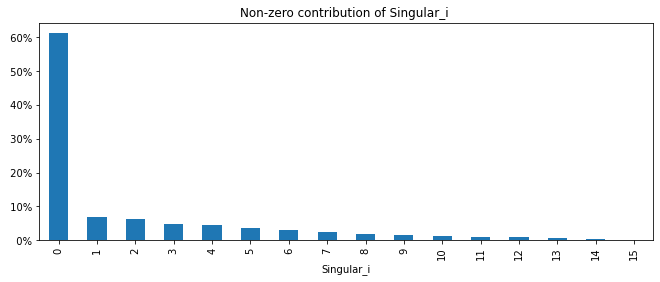

In [16]:
ssa.view_s_contributions()

What do the modes look like?

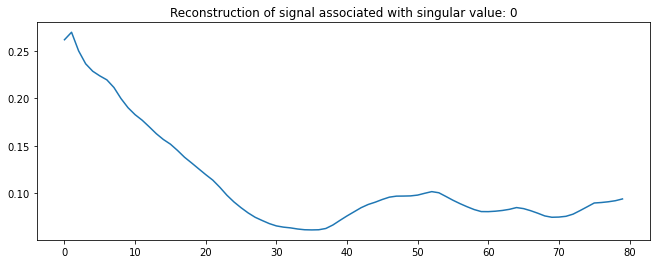

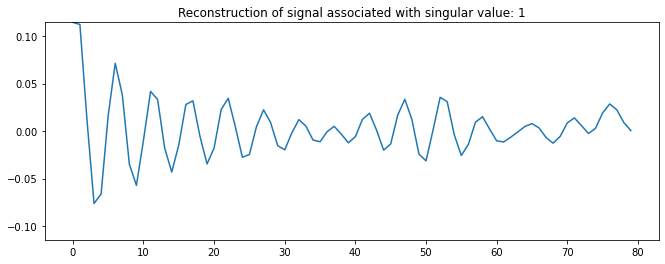

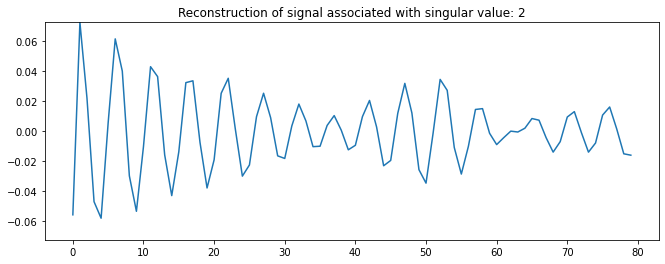

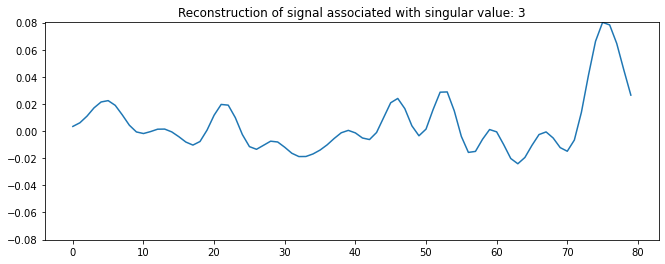

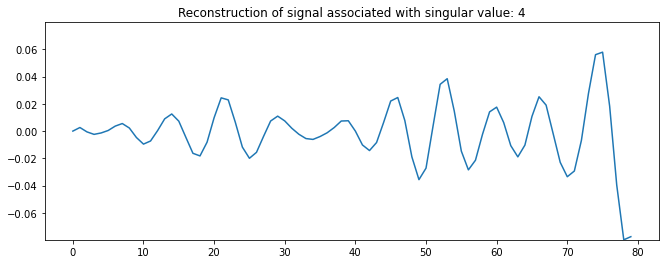

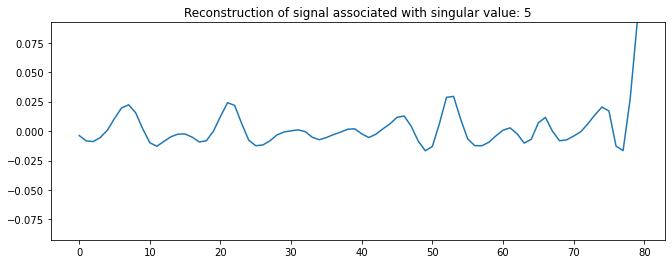

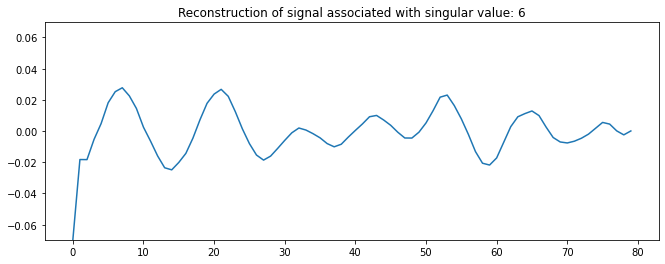

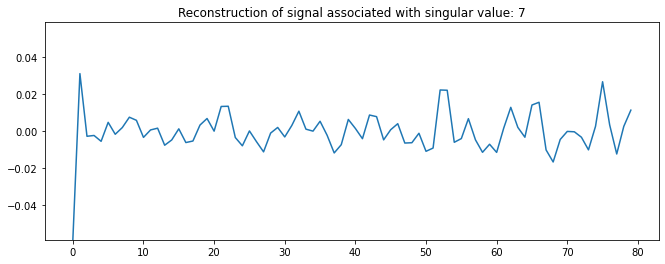

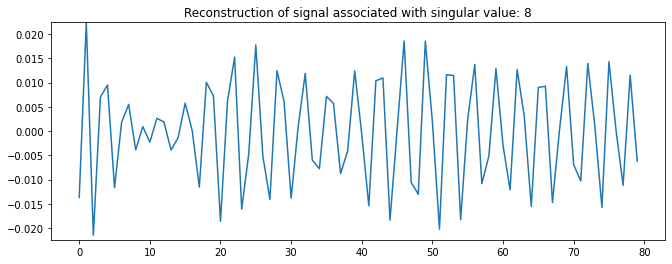

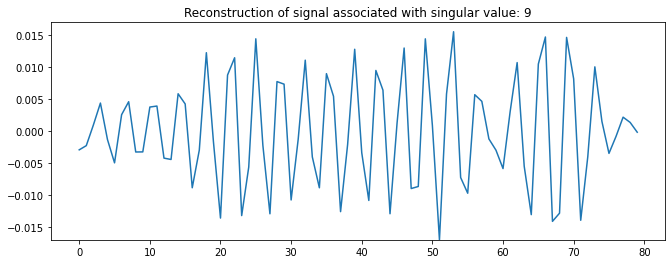

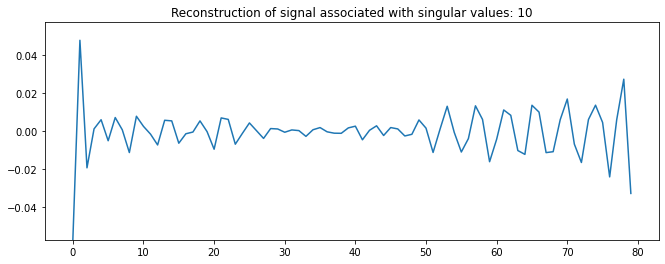

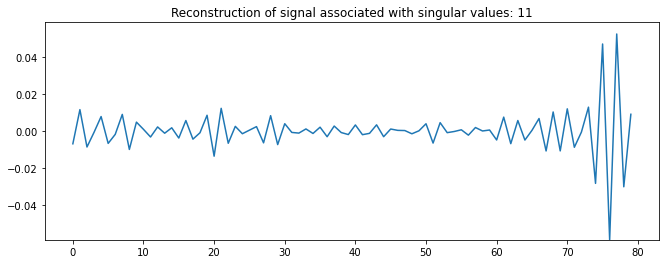

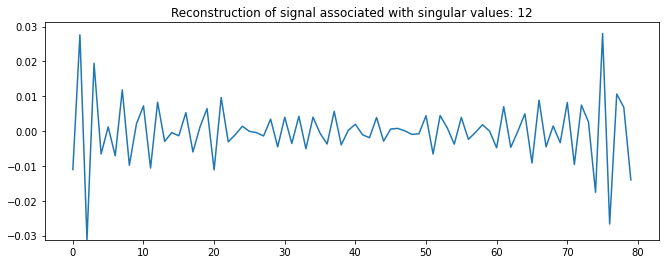

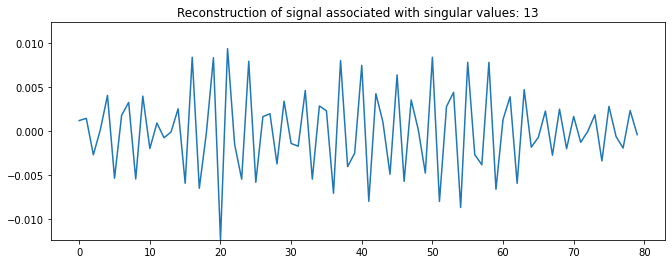

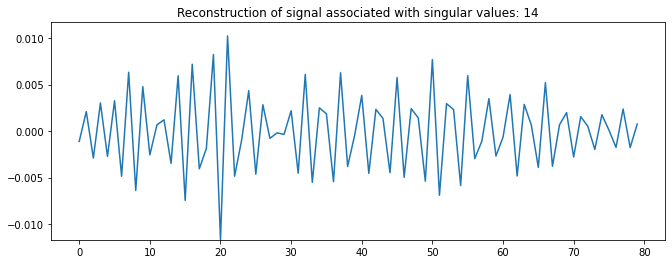

In [17]:


for i in range(15):
    ssa.view_reconstruction(ssa.Xs[i], names=i, symmetric_plots=i!=0)



re constrcut the signal with 10 modes

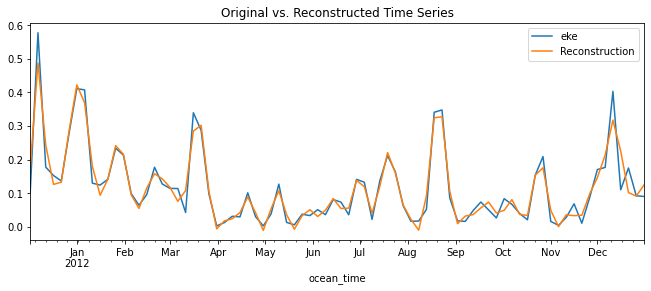

In [18]:
streams10 = [i for i in range(10)]
reconstructed10 = ssa.view_reconstruction(*[ssa.Xs[i] for i in streams10], 
                                          names=streams10, return_df=True, plot=False)
ts_copy10 = ssa.ts.copy()
ts_copy10['Reconstruction'] = reconstructed10.Reconstruction.values
ts_copy10.plot(title='Original vs. Reconstructed Time Series');

Not just a smoother.... Can also forecast

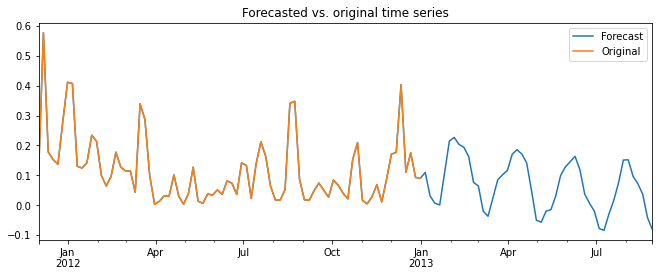

In [19]:
ssa.forecast_recurrent(steps_ahead=48, singular_values=streams10, plot=True)

And can separate noise from trend and periodic features

Apply to a spatial map!


In [20]:
# Functions
from log_progress import log_progress
from mySSA import mySSA
import pandas as pd
from scipy import signal

def get_var_map(ts_map,K):
    
    var_map = np.tile(np.zeros_like(ts_map[0].values),(4,1,1))
    
    for j in log_progress(ts_map.eta_rho.values,name='eta'):
        for i in ts_map.xi_rho.values:
             var_map[:,j,i] = get_var(ts_map[:,j,i],K)

    return var_map

def get_var(ts_cell,K):
    # expects input as a xarray, then will convert to pandas dataframe
    # also make sure to remove any other coordinates/variables (except for time coordinate)
    
    if np.var(ts_cell.values) == 0.0:
        var_slow,var_fast,var_slow_contr,var_fast_contr = 0,0,0,0
        
    else:
        
        ts = ts_cell.copy()
        ts[:] = signal.detrend(ts_cell.values,-1,'linear')
        ssa = mySSA(ts.to_dataframe())

        ssa.embed(embedding_dimension=K)
        ssa.decompose()

        slow_rho_idx = np.argmax(np.abs(ssa.U.sum(0))/(np.abs(ssa.U).sum(0)))
        fast_rho_idx = np.delete(range(K),slow_rho_idx)

        var_slow,var_slow_contr = ssa.s[slow_rho_idx],ssa.s_contributions.values[slow_rho_idx][0]
        var_fast,var_fast_contr = sum(np.delete(ssa.s,slow_rho_idx)),sum(np.delete(ssa.s_contributions.values.squeeze(),slow_rho_idx))
    
    return var_slow,var_slow_contr,var_fast,var_fast_contr


In [22]:
input = ds.eke.isel(s_rho=-1)

input = input.fillna(0) # remove any nan values

mask = ~(input.isel(ocean_time=0)==0) # make mask now


input = input.drop(['lon_rho','lat_rho','z_rho','z_rho0','s_rho']) #drop extra coords

eke_var_map_12 = get_var_map(input,12)


ds["eke_var_map_12_slow"] = (('eta_rho','xi_rho'),eke_var_map_12[1])
ds["eke_var_map_12_fast"] = (('eta_rho','xi_rho'),eke_var_map_12[3])


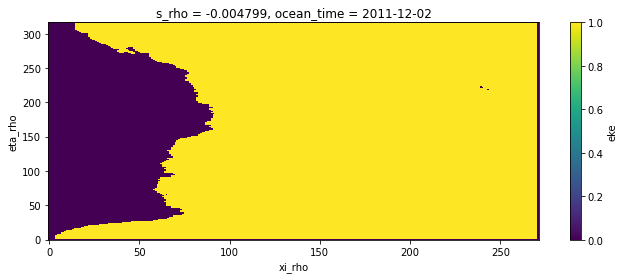

In [23]:
mask.plot()

<Figure size 792x288 with 0 Axes>

/g/data/fu5/deg581/miniconda3/envs/devel3.9/lib/python3.9/site-packages/shapefile.py:391: UserWarning: Shapefile shape has invalid polygon: no exterior rings found (must have clockwise orientation); interpreting holes as exteriors.
  warnings.warn('Shapefile shape has invalid polygon: no exterior rings found (must have clockwise orientation); interpreting holes as exteriors.')


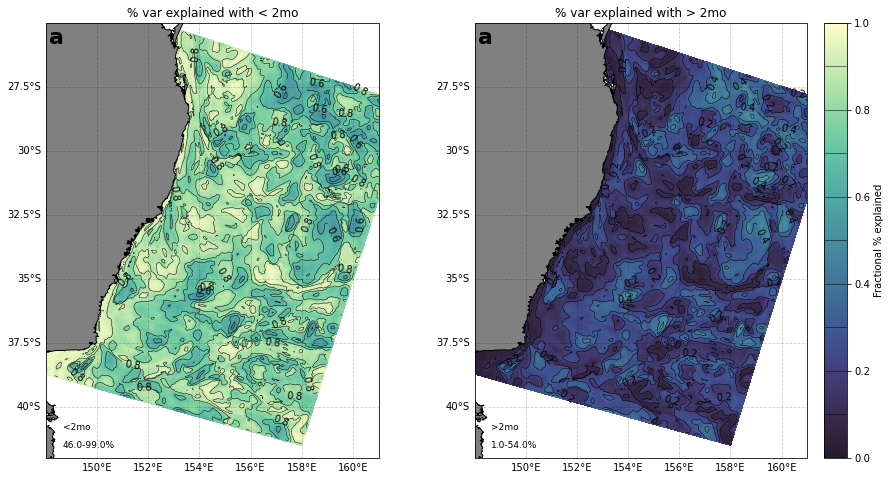

In [24]:
gs = gridspec.GridSpec(nrows=1,ncols=2,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,8])
ax = None

ax=fig.add_subplot(gs[0,0],projection=ccrs.PlateCarree())
ax.set_extent([148, 161, -42, -25])
feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray', label='_nolegend_')
im=ax.pcolormesh(ds.lon_rho,ds.lat_rho,ds.eke_var_map_12_fast.where(mask),vmin=0,vmax=1,cmap='cmo.deep_r')
co=ax.contour(ds.lon_rho,ds.lat_rho,ds.eke_var_map_12_fast.where(mask),colors='k',levels=np.arange(0,1.1,.1),linewidths=0.5)
gl = ax.gridlines(draw_labels=True,color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
# gl.left_labels = False
ax.clabel(co,levels=np.arange(0,1.2,.2),inline=True)
ax.set_title('% var explained with < 2mo')
ax.text(0.01, 0.99, 'a', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
ax.text(.05, .07, '<2mo',fontsize=9, va='center', ha='left', transform=ax.transAxes)
ax.text(.05, .03,  str((ds.eke_var_map_12_fast.where(mask).min()*100).round().values)+'-'+str((ds.eke_var_map_12_fast.where(mask)*100).max().round().values)+'%',fontsize=9, va='center', ha='left', transform=ax.transAxes)

ax=fig.add_subplot(gs[0,1],projection=ccrs.PlateCarree())
ax.set_extent([148, 161, -42, -25])
feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray', label='_nolegend_')
im=ax.pcolormesh(ds.lon_rho,ds.lat_rho,ds.eke_var_map_12_slow.where(mask),vmin=0,vmax=1,cmap='cmo.deep_r')
co=ax.contour(ds.lon_rho,ds.lat_rho,ds.eke_var_map_12_slow.where(mask),colors='k',levels=np.arange(0,1.1,.1),linewidths=0.5)
gl = ax.gridlines(draw_labels=True,color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
# gl.left_labels = False
ax.clabel(co,levels=np.arange(0,1.2,.2),inline=True)
ax.set_title('% var explained with > 2mo')
ax.text(0.01, 0.99, 'a', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
ax.text(.05, .07, '>2mo',fontsize=9, va='center', ha='left', transform=ax.transAxes)
ax.text(.05, .03,  str((ds.eke_var_map_12_slow.where(mask).min()*100).round().values)+'-'+str((ds.eke_var_map_12_slow.where(mask)*100).max().round().values)+'%',fontsize=9, va='center', ha='left', transform=ax.transAxes)


cax = inset_axes(ax,
                 width="7%",  # width = 10% of parent_bbox width
                 height="100%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(1.05,0, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
cbar = fig.colorbar(im, cax=cax)
cbar.ax.set_ylabel('Fractional % explained')
cbar.add_lines(co)